In [2]:
import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
PATCH_SIZE = 16  # pixels per side of square patches
VAL_SIZE = 10  # size of the validation set (number of images)
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

In [6]:
ROOT_PATH = "/Users/sebastian/University/Master/second_term/cil/road-segmentation/ethz-cil-road-segmentation-2024"

In [7]:
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.

In [21]:
def show_image_and_mask(imgs, masks, n):
    # Displays the specified image and its corresponding mask at index n
    if n < len(imgs) and n < len(masks):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(imgs[n])
        axs[0].set_title(f'Image {n}')
        axs[0].set_axis_off()
        axs[1].imshow(masks[n])
        axs[1].set_title(f'Mask {n}')
        axs[1].set_axis_off()
        plt.show()
    else:
        print(f"Index {n} out of range. Provide a valid index within the range of images and masks.")

In [22]:
images = load_all_from_path(os.path.join(ROOT_PATH, 'training', 'images'))[:, :, :, :3]
masks = load_all_from_path(os.path.join(ROOT_PATH, 'training', 'groundtruth'))

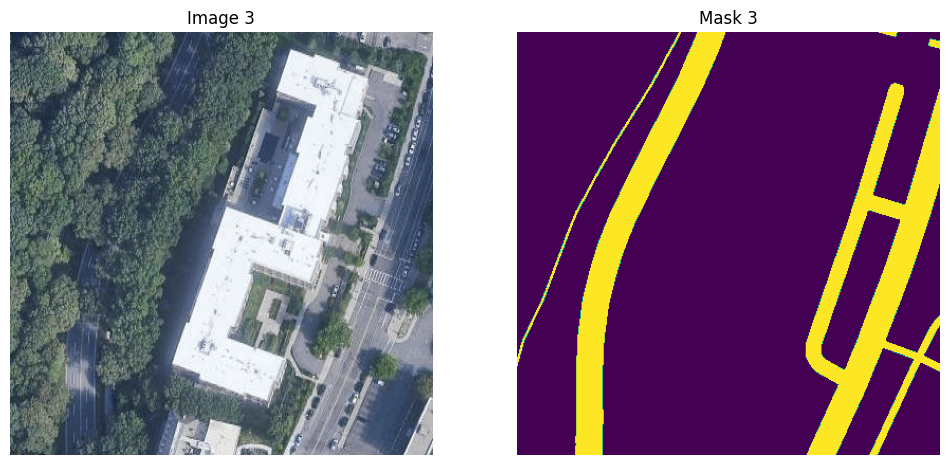

In [30]:
show_image_and_mask(images, masks, 3)

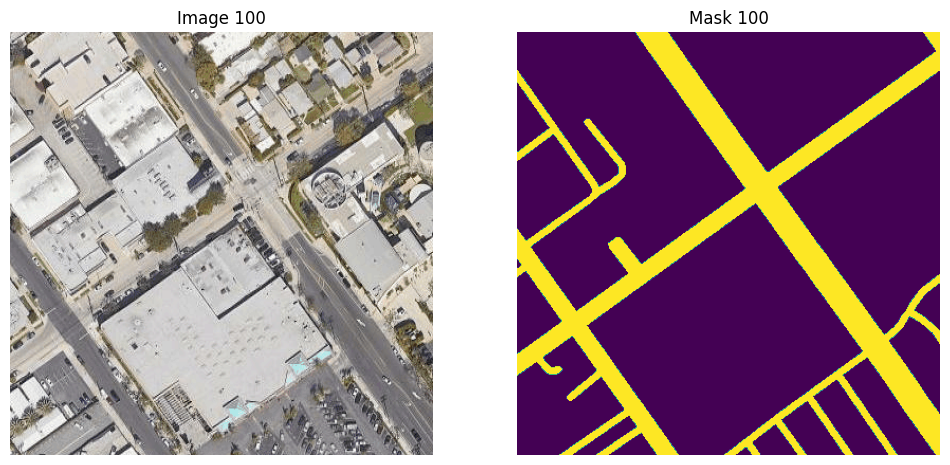

In [29]:
show_image_and_mask(images, masks, 100)

In [39]:
import cv2

def run_histogram_equalization(rgb_img):

    R, G, B = cv2.split(rgb_img)

    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)

    equ = cv2.merge((output1_R, output1_G, output1_B))


    cv2.imshow('equalized_img', equ)
    cv2.waitKey(0)

In [40]:
run_histogram_equalization(images[3])

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/histogram.cpp:3440: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'equalizeHist'


In [43]:
cv2.equalizeHist(cv2.split(images[3])[0])

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/histogram.cpp:3440: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'equalizeHist'


In [52]:
res = cv2.split(images[3])[0]

In [54]:
cv2.equalizeHist(res)

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/histogram.cpp:3440: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'equalizeHist'


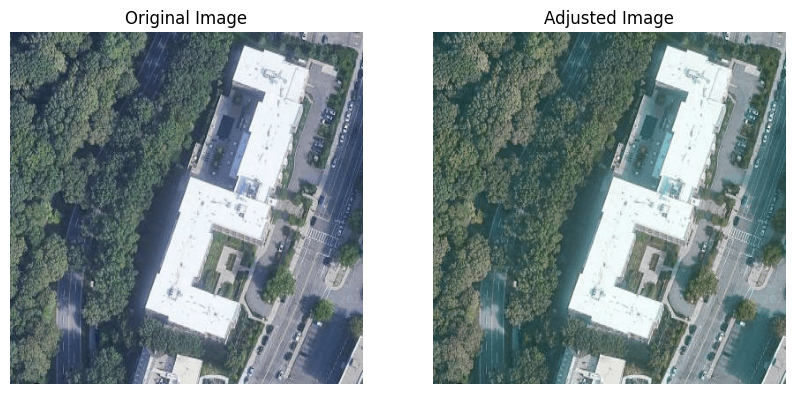

In [63]:
import cv2
import numpy as np

# Load the image
image = images[3]
# Convert the image to the HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Split the image into its Hue, Saturation, and Value components
hue, saturation, value = cv2.split(hsv_image)

# Apply shadow attenuation by adjusting the Hue component
# Example: Increase the Hue value by 10 (adjust to your specific needs)
hue_adjusted = np.clip(hue + 30, 0, 179)  # Hue values range from 0 to 179
hsv_image_adjusted = cv2.merge([hue_adjusted, saturation, value])
adjusted_image = cv2.cvtColor(hsv_image_adjusted, cv2.COLOR_HSV2BGR)
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Adjusted Image
plt.subplot(1, 2, 2)
plt.imshow(adjusted_image)
plt.title('Adjusted Image')
plt.axis('off')

plt.show()


In [66]:
images[3]*255

array([[[ 28.,  44.,  60.],
        [ 24.,  36.,  52.],
        [ 24.,  36.,  52.],
        ...,
        [131., 132., 147.],
        [131., 132., 147.],
        [130., 131., 131.]],

       [[ 28.,  44.,  60.],
        [ 24.,  36.,  52.],
        [ 33.,  49.,  65.],
        ...,
        [166., 166., 170.],
        [155., 155., 162.],
        [147., 150., 164.]],

       [[ 28.,  44.,  60.],
        [ 28.,  44.,  60.],
        [ 41.,  57.,  73.],
        ...,
        [182., 182., 182.],
        [159., 159., 171.],
        [166., 166., 170.]],

       ...,

       [[ 51.,  65.,  81.],
        [ 33.,  49.,  65.],
        [ 51.,  65.,  81.],
        ...,
        [167., 171., 183.],
        [ 90., 108., 114.],
        [ 98., 113., 108.]],

       [[ 42.,  58.,  65.],
        [ 33.,  49.,  65.],
        [ 58.,  73.,  90.],
        ...,
        [130., 131., 131.],
        [ 92.,  99.,  99.],
        [ 92., 100., 116.]],

       [[ 40.,  52.,  68.],
        [ 51.,  65.,  81.],
        [ 58.,  

In [73]:
import cv2
import numpy as np

img = (images[3]*255).astype(int)



rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    print(dilated_img)
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)
    
result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

cv2.imwrite('shadows_out.png', result)
cv2.imwrite('shadows_out_norm.png', result_norm)

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/morph.simd.hpp:756: error: (-213:The function/feature is not implemented) Unsupported data type (=4) in function 'getMorphologyRowFilter'


In [75]:
img

array([[[ 28,  44,  60],
        [ 24,  36,  52],
        [ 24,  36,  52],
        ...,
        [131, 132, 147],
        [131, 132, 147],
        [130, 131, 131]],

       [[ 28,  44,  60],
        [ 24,  36,  52],
        [ 33,  49,  65],
        ...,
        [166, 166, 170],
        [155, 155, 162],
        [147, 150, 164]],

       [[ 28,  44,  60],
        [ 28,  44,  60],
        [ 41,  57,  73],
        ...,
        [182, 182, 182],
        [159, 159, 171],
        [166, 166, 170]],

       ...,

       [[ 51,  65,  81],
        [ 33,  49,  65],
        [ 51,  65,  81],
        ...,
        [167, 171, 183],
        [ 90, 108, 114],
        [ 98, 113, 108]],

       [[ 42,  58,  65],
        [ 33,  49,  65],
        [ 58,  73,  90],
        ...,
        [130, 131, 131],
        [ 92,  99,  99],
        [ 92, 100, 116]],

       [[ 40,  52,  68],
        [ 51,  65,  81],
        [ 58,  73,  90],
        ...,
        [ 92,  99,  99],
        [ 84,  92, 100],
        [ 92,  99,  99]]